<a href="https://colab.research.google.com/github/liadmagen/NLP-Course/blob/master/exercises_notebooks_solutions/04_LM_PP_Attachment_classification__solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PP Attachment 

The Preposition Phrase attachment problem is the difficulty to decide if a preposition in a sentence is attached to a verb or a noun.

In some cases it may even confuse the reader. For example, the sentence:

> San Jose cops kill man with a knife

can be interpreted as either the man or the cops had a knife. The difference in the syntax parsing would be attaching the preposition phrase either to the Verb Phrase ("kill with knife")

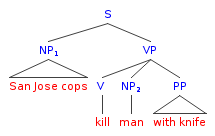

or to the Noun Phrase ("man with knife").

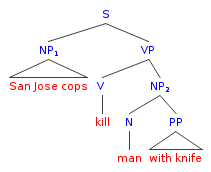


Let's try out the Preposition Phrase attachment classification!

Through this exercise, you'll practice classification of linguistic aspects of text.

# Setup
Loading the data

In [1]:
import csv

from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from random import choice
from urllib.request import urlopen


In [2]:
def read_pp_examples(file_url: str) -> List[Dict]:
  """Reads the pp samples from a remtoe url and loads them into a dictionary

  Args:
      file_url (str): a url to load the dataset from

  Returns:
      Dict: a dictionary with two keys: answer and pp
  """
  pp_examples = []
  
  for line in tqdm(urlopen(file_url)):
    line = line.decode("utf-8").strip().split()
    assert(len(line) == 5)
    v,n1,p,n2,answer = line
    pp_examples.append( {'answer':answer,'keywords':(v,n1,p,n2)} )
  return pp_examples

In [3]:
pp_samples_url = 'https://raw.githubusercontent.com/liadmagen/NLP-Course/master/dataset/pp_examples.txt'

In [4]:
pp_examples = read_pp_examples(pp_samples_url)


0it [00:00, ?it/s]

# Step #1 - Look at the data

Step 1 is (always) to examine the data!

That means to check the data statistics, load some sample at random and ensure it is correctly labeled, and if possible, plot and visualize the data (histograms, distribution, etc.). 

In [5]:
print(f"There are {len(pp_examples)} samples in the dataset")

There are 25858 samples in the dataset


In [6]:
print(choice(pp_examples))

{'answer': 'N', 'keywords': ('offer', 'security', 'of', 'markets')}


Of course, we can reach the dictionary's parts by specifying the key in a squared brackets. 

In [7]:
random_example = choice(pp_examples)
random_example['keywords']

('cause', 'loss', 'of', 'contracts')

In [8]:
random_example['answer']

'N'

# Step 2: Deciding on the measurement

In [9]:
# we can split the dataset simply through dividing the list 

amt = int(0.75 * len(pp_examples))
train_examples, test_examples = pp_examples[:amt], pp_examples[amt:]

print(len(train_examples), len(test_examples))

19393 6465


We'll define a classifier evaluator.

Given a set of examples and an evaluator, it returns the accuracy score

In [10]:
def evaluate_classifier(examples, pp_resolver):
  """evaluate the classifier and returns the accuracy score.

  Args:
      examples (List): a list of {'keywords':(v,n1,p,n2), 'answer':answer }
      pp_resolver (_type_): a model with a classify() function that maps from 
        (v,n1,p,n2) to 'N' / 'V'

  Returns:
      float: The accurcy score of the classifier
  """
  correct = 0.0
  incorrect = 0.0
  for example in examples:
      answer = pp_resolver.classify(example['keywords'])
      if answer == example['answer']:
          correct += 1
      else:
          incorrect += 1
  return correct / (correct + incorrect)


# Classifiers

Let's test it on an extremely naive classifiers:

In [11]:
class AlwaysSayN:
    """
    This naive clasifier answers always with 'Noun'
    """
    def __init__(self): pass
    def classify(self, pp):
        return 'N'


In [12]:
class AlwaysSayV:
    """
    This naive clasifier answers always with 'Verb'
    """
    def __init__(self): pass
    def classify(self, pp):
        return 'V'


In [13]:
evaluate_classifier(test_examples, AlwaysSayV())

0.4634184068058778

In [14]:
evaluate_classifier(test_examples, AlwaysSayN())

0.5365815931941222

We can see that saying always 'Noun', leads to an accuracy result of 53%.

---



It also means that our dataset is quite balaneced ;)

We could, instead, have tested which class has the majority and simply select it:

In [15]:
class MajorityClassResolver:
  def __init__(self, training_examples: List):
    """Initializes the class, testing which class is the majority and saves it as a property.

    Args:
        training_examples (List): A list of dictionary training examples.
    """
    answers = [item['answer'] for item in training_examples]
    num_n = len([a for a in answers if a == 'N'])
    num_v = len([a for a in answers if a == 'V'])
    if num_v > num_n:
        self.answer = 'V'
    else:
        self.answer = 'N'

  def classify(self, pp: Tuple) -> str:
    """classify a 4 keywords tuple as N or V attachment, based on the previously calculated majority class

    Args:
        pp (Tuple): a tuple of V, N1, PP, N2 to be classified

    Returns:
        str: the prediction - N or V
    """
    return self.answer


In [16]:
evaluate_classifier(test_examples, MajorityClassResolver(train_examples))

0.5365815931941222

Or make it a bit more sophisticated by peeking at the training examples:

In [17]:
class LookupResolver:
  def __init__(self, training_examples: List):
    """Initializes the class, load all the training dataset into the memory and during prediction, return the answer if the keywords match a previously saved one. 

    Args:
        training_examples (List): _description_
    """
    self.answers = {}
    for item in training_examples:
        self.answers[item['keywords']] = item['answer']
    self.backoff = MajorityClassResolver(training_examples)
      
  def classify(self, pp: Tuple) -> str:
    """Classify a 4 keywords tuple as N or V attachment.
     If the tuple was found in the previously stored answers, return it.
     Otherwise, return the majority class.

    Args:
        pp (Tuple): a tuple of V, N1, PP, N2 to be classified

    Returns:
        str: the prediction - N or V
    """
    if pp in self.answers:
        return self.answers[pp]
    else:
        return self.backoff.classify(pp)

In [18]:
# If you want to understand what is stored in the `answers` property, uncomment and run the following line:
# LookupResolver(train_examples).answers

In [19]:
evaluate_classifier(test_examples, LookupResolver(train_examples))

0.6009280742459396

# Exercise - Your Turn:

Implement a discriminative PP-attachment model, using a classifier of your choice (i.e. - Naive Bayes Classifier https://web.stanford.edu/~jurafsky/slp3/4.pdf, [Support Vector Machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), etc.) from a toolkit such as [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB).

Possible features for back-off algorithm or ML one:

Single items ​
* Identity of v ​
* Identity of p ​
* Identity of n1 ​
* Identity of n2 ​

Pairs:​
* dentity of (v, p) ​
* Identity of (n1, p) ​
* Identity of (p, n1)​

Triplets:​
* Identity of (v, n1, p)​
* Identity of (v, p, n2) ​
* Identity of (n1, p, n2) ​

Quadruple:​
* Identity of (v, n1, p, n2)​


Corpus Level:​

* Have we seen the (v, p) pair in a 5-word window in a big corpus?​
* Have we seen the (n1, p) pair in a 5-word window in a big corpus? ​
* Have we seen the (n1, p, n2) triplet in a 5-word window in a big corpus?​
*  Also: we can use counts, or binned counts.​
* You can use a bigger corpus for additional training purposes as well.

Distance:​
* Distance (in words) between v and p ​
* Distance (in words) between n1 and p​

For the corpus level features, you can simply load one of the english corpuses in NLTK (such as [brown - but don't forget to download it first](https://www.nltk.org/book/ch02.html)). If you use a tagged corpus - such that the words are tagged by their parts of speech, you can create more interesting linguistic-related features.

You can also consider using [WordNet](https://wordnet.princeton.edu/), a large *lexical* database of English words, which is also [implemented in NLTK](https://www.nltk.org/howto/wordnet.html). 

Finally, if you need inspiration and ideas, here are some selected papers:
- [An Analysis of Prepositional-Phrase Attachment Disambiguation](http://ejournals.asia/stj1/ijclr2.pdf) - an overview of different papers dealing with this problem using different methods (kNN, SVN, etc.).
- [The spy saw a cop with a telescope: Who has the telescope?](https://www.semanticscholar.org/paper/The-spy-saw-a-cop-with-a-telescope%3A-Who-has-the-Yan-Nguyen/3220ad0619b72404cb9b1acb9e093a8a564f0f4e) - An linguistic analysis of the potentials reasons (and features) to disambiguify pp attachment. 
- [PREPOSITIONAL PHRASE ATTACHMENT AMBIGUITY RESOLUTION USING SEMANTIC HIERARCHIES](https://eprints.mdx.ac.uk/2471/1/ppattachhier.pdf)
- [Corpus Based PP Attachment Ambiguity Resolution with a Semantic Dictionary](https://aclanthology.org/W97-0109.pdf)

## First step - having a PROPER look at the data

Personally, I find it convenient to use pandas, but this is not a must.

In [20]:
import nltk
import pandas as pd

df = pd.DataFrame([ex['keywords'] for ex in train_examples], columns=['v', 'n1', 'p', 'n2'])
df['target'] = [ex['answer'] for ex in train_examples]
df_codes = pd.DataFrame()

for col in df.columns:
  df[col] = df[col].str.lower().astype('category')
  df_codes[col] = df[col].cat.codes

df.describe().T

,count,unique,top,freq
v,19393,2990,is,759
n1,19393,3970,%,1302
p,19393,62,of,5049
n2,19393,4792,$,1227
target,19393,2,n,10625


### Preposition distribution

In [21]:
nltk.FreqDist(df[df['target']=='n']['p'])

FreqDist({'of': 4838, 'in': 1499, 'for': 1170, 'on': 612, 'to': 460, 'from': 375, 'with': 367, 'at': 179, 'as': 172, 'by': 154, ...})

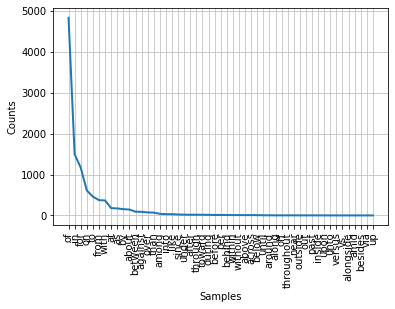

In [22]:
nltk.FreqDist(df[df['target']=='n']['p']).plot()

In [23]:
nltk.FreqDist(df[df['target']=='v']['p'])

FreqDist({'in': 1847, 'to': 1541, 'for': 905, 'from': 836, 'on': 585, 'with': 512, 'at': 507, 'as': 334, 'by': 268, 'of': 211, ...})

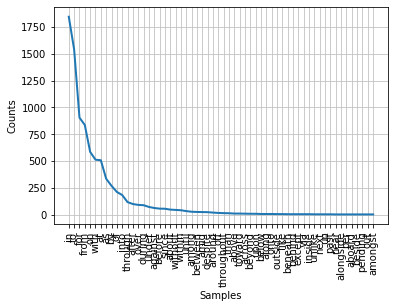

In [24]:
nltk.FreqDist(df[df['target']=='v']['p']).plot()

In [25]:
df[df['p']=='throughout']

,v,n1,p,n2,target
471,had,conversations,throughout,weekend,v
562,dominated,trading,throughout,session,v
821,enjoyed,increase,throughout,1989,v
1891,following,declines,throughout,1980s,n
2094,selling,stock,throughout,week,v
4395,showed,strength,throughout,session,v
5759,show,lines,throughout,city,n
5940,bedevil,economy,throughout,1990s,v
7026,are,payers,throughout,stay,v
8173,operates,restaurants,throughout,u.s.,n


#### Preposition Distribution - summary

We can see that some prepositions ('of', 'from', 'to') tends to belong to a single class, while some others ('in', 'for') are nearly half-half between the classes.

### Distribution of the rest of the classes

In [26]:
df['v'].value_counts().head(20)

is           759
rose         388
had          374
was          338
have         271
are          247
be           243
has          233
buy          205
fell         168
reported     168
sell         156
make         144
's           142
been         133
made         130
increased    129
take         123
posted       111
put          110
Name: v, dtype: int64

Many words seem to be in different forms (past, present). Let's check if there are differences: 

In [27]:
df[df['v']=='increased']['target'].value_counts()

v    108
n     21
Name: target, dtype: int64

In [28]:
df[df['v']=='increase']['target'].value_counts()

v    54
n    45
Name: target, dtype: int64

In [29]:
df[df['v']=='reported']['target'].value_counts()

n    151
v     17
Name: target, dtype: int64

In [30]:
df[df['v']=='report']['target'].value_counts()

n    59
v    15
Name: target, dtype: int64

In [31]:
df[df['v'].str.startswith('report')]['target'].value_counts()

n    220
v     34
Name: target, dtype: int64

In [32]:
df['n1'].value_counts()

%                1302
stake             202
loss              189
shares            155
part              154
                 ... 
nerves              1
neighborhoods       1
corporations        1
corpse              1
zip                 1
Name: n1, Length: 3970, dtype: int64

In [33]:
df['n2'].value_counts()

$           1227
%            274
market       217
quarter      198
years        177
            ... 
lumpur         1
camps          1
lyondell       1
lyonnais       1
zone           1
Name: n2, Length: 4792, dtype: int64

In [34]:
df['n2'].value_counts().head(20)

$            1227
%             274
market        217
quarter       198
years         177
company       148
year          134
shares        134
yen           114
months        101
time           92
trading        87
stock          84
inc.           81
u.s.           81
markets        77
companies      73
corp.          72
business       69
september      68
Name: n2, dtype: int64

In [35]:
df[df['n1']=='%']

,v,n1,p,n2,target
32,distribute,%,of,revenues,n
33,distribute,%,as,grants,v
75,dropped,%,to,$,v
76,dropped,%,from,$,v
77,fell,%,to,$,v
...,...,...,...,...,...
19271,declined,%,to,$,v
19272,declined,%,from,$,v
19273,rose,%,to,$,v
19274,rose,%,from,$,v


In [36]:
df[df['n1']=='%']['target'].value_counts()

v    988
n    314
Name: target, dtype: int64

In [37]:
df[df['n2']=='$']

,v,n1,p,n2,target
4,leaving,spending,at,$,v
75,dropped,%,to,$,v
76,dropped,%,from,$,v
77,fell,%,to,$,v
78,fell,%,from,$,v
...,...,...,...,...,...
19275,closed,yesterday,at,$,v
19279,buy,company,for,$,v
19343,had,revenue,of,$,n
19344,closed,yesterday,at,$,v


In [38]:
df[df['n2']=='$']['target'].value_counts()

v    781
n    446
Name: target, dtype: int64

In [39]:
df[df['n2']=='$']['target'].value_counts()

v    781
n    446
Name: target, dtype: int64

In [40]:
df[df['n2']=='years']['target'].value_counts()

v    134
n     43
Name: target, dtype: int64

In [41]:
df[df['n2']=='year']['target'].value_counts()

v    76
n    58
Name: target, dtype: int64

In [42]:
df[df['n2']=='months']['target'].value_counts()

v    74
n    27
Name: target, dtype: int64

In [43]:
df[df['n2']=='month']['target'].value_counts()

v    14
n     5
Name: target, dtype: int64

It seems that many of the nouns appear in singular/pluarl forms, and in some cases both forms actually lead to the same result distribution. 

## Simple attempt with Naive Bayes

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

class NaiveBayesClassifier:
  """
  This naive bayes clasifier is trained using a Multinomial Naive Bayes
  """
  def __init__(self, training_examples: List):

    # convert the data into lists (of sentences / of V/N chars)
    X = [' '.join(example['keywords']) for example in training_examples]
    y = [example['answer'] for example in training_examples]

    # convert the text into numerical values. Here we use simple frequency
    self.vectorizer = CountVectorizer()
    # fit_transforms fits the vectorizer on the test and converts it to vector
    X_transformed = self.vectorizer.fit_transform(X)

    # create a classifier and train it on the data
    self.classifier = MultinomialNB()
    self.classifier.fit(X_transformed, y)

  def classify(self, pp: Tuple):
    # converting the 4-words tuple into a sentnce, separated with spaces: 
    joined_sentence = " ".join(pp)
    # Vectorizing the sentence.
    # The vectorizer accepts a list of sentences, even if we only have one...
    vectorized_sentence = self.vectorizer.transform([joined_sentence])
    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, NaiveBayesClassifier(train_examples))

0.794431554524362

### Naive bayes with a bigger (brown) corpus

In [45]:
import nltk
from nltk.corpus import brown
nltk.download('brown')

class NaiveBayesWithBrownTokenizerClassifier:
  """
  This model fits the vectorizer on a bigger corpus (brown).
  The clasifier is trained using a Multinomial Naive Bayes
  """
  def __init__(self, training_examples: List):

    # convert the data into lists (of sentences / of V/N chars)
    X = [' '.join(example['keywords']) for example in training_examples]
    y = [example['answer'] for example in training_examples]

    # convert the text into numerical values. Here we use simple frequency
    self.vectorizer = CountVectorizer()
    # fit the vectorizer on the brown corpus
    corpus = [" ".join(sent) for sent in brown.sents()]
    self.vectorizer.fit(corpus)
    
    # use the vectorizer to transform the training data into to vector
    X_transformed = self.vectorizer.fit_transform(X)

    # create a classifier and train it on the data
    self.classifier = MultinomialNB()
    self.classifier.fit(X_transformed, y)

  def classify(self, pp: Tuple):
    # converting the 4-words tuple into a sentnce, separated with spaces: 
    joined_sentence = " ".join(pp)
    # Vectorizing the sentence.
    # The vectorizer accepts a list of sentences, even if we only have one...
    vectorized_sentence = self.vectorizer.transform([joined_sentence])
    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, NaiveBayesWithBrownTokenizerClassifier(train_examples))

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


0.794431554524362

Seems to have no affect.

### Naive bayes  with additional lemmatized features

In [46]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')

class NaiveBayesWithLemmaFeaturesClassifier:
  """
  This model adds additional features as lemmatized nouns and verbs.
  The clasifier is trained using a Multinomial Naive Bayes
  """
  def __init__(self, training_examples: List):
    self.lemmatizer = WordNetLemmatizer()
    
    # convert the data into lists (of sentences / of V/N chars)
    X = [' '.join(example['keywords']) for example in training_examples]
    y = [example['answer'] for example in training_examples]

    # convert the text into numerical values. Here we use simple frequency
    self.vectorizer = CountVectorizer()
    X_transformed = self.vectorizer.fit_transform(X)
    
    # create a classifier and train it on the data
    self.classifier = MultinomialNB()
    self.classifier.fit(X_transformed, y)

  def transform_example(self, example: Tuple) -> List:
    lemmatized_v = self.lemmatizer.lemmatize(example[0], 'v')
    lemmatized_n1 = self.lemmatizer.lemmatize(example[1], 'n')
    lemmatized_n2 = self.lemmatizer.lemmatize(example[3], 'n')

    features = set([lemmatized_v, lemmatized_n1, lemmatized_n2] + list(example))
    return " ".join(features)
    
  def classify(self, pp: Tuple):
    # converting the 4-words tuple into a sentnce, together with the lemmas: 
    joined_sentence = self.transform_example(pp)
    # Vectorizing the sentence.
    # The vectorizer accepts a list of sentences, even if we only have one...
    vectorized_sentence = self.vectorizer.transform([joined_sentence])
    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, NaiveBayesWithLemmaFeaturesClassifier(train_examples))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0.7899458623356536

## Support Vector Machine

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

class SupportVectorClassifier:
  """
  This naive bayes clasifier is trained using a Support Vector Machine
  """
  def __init__(self, training_examples: List):

    # convert the data into lists (of sentences / of V/N chars)
    X = [' '.join(example['keywords']) for example in training_examples]
    y = [example['answer'] for example in training_examples]

    # convert the text into numerical values. Here we use simple frequency
    self.vectorizer = CountVectorizer()
    # fit_transforms fits the vectorizer on the test and converts it to vector
    X_transformed = self.vectorizer.fit_transform(X)

    # create a classifier and train it on the data
    self.classifier = SVC()
    self.classifier.fit(X_transformed, y)

  def classify(self, pp: Tuple):
    # converting the 4-words tuple into a sentnce, separated with spaces: 
    joined_sentence = " ".join(pp)
    # Vectorizing the sentence.
    # The vectorizer accepts a list of sentences, even if we only have one...
    vectorized_sentence = self.vectorizer.transform([joined_sentence])
    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, SupportVectorClassifier(train_examples))

0.8218097447795824

### Support Vector Machine with brown corpus

In [48]:

class SVCWithBrownTokenizerClassifier:
  """
  This model fits the vectorizer on a bigger corpus (brown).
  The clasifier is trained using a Support Vector Machine
  """
  def __init__(self, training_examples: List):

    # convert the data into lists (of sentences / of V/N chars)
    X = [' '.join(example['keywords']) for example in training_examples]
    y = [example['answer'] for example in training_examples]

    # convert the text into numerical values. Here we use simple frequency
    self.vectorizer = CountVectorizer()
    # fit the vectorizer on the brown corpus
    corpus = [" ".join(sent) for sent in brown.sents()]
    self.vectorizer.fit(corpus)
    
    # use the vectorizer to transform the training data into to vector
    X_transformed = self.vectorizer.fit_transform(X)

    # create a classifier and train it on the data
    self.classifier = SVC()
    self.classifier.fit(X_transformed, y)

  def classify(self, pp: Tuple):
    # converting the 4-words tuple into a sentnce, separated with spaces: 
    joined_sentence = " ".join(pp)
    # Vectorizing the sentence.
    # The vectorizer accepts a list of sentences, even if we only have one...
    vectorized_sentence = self.vectorizer.transform([joined_sentence])
    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, SVCWithBrownTokenizerClassifier(train_examples))

0.8218097447795824

### Support Vector Machine with Lemmatized Features

In [49]:
class SVCWithLemmaFeaturesClassifier:
  """
  This model adds additional features as lemmatized nouns and verbs.
  The clasifier is trained using a Support Vector Machine
  """
  def __init__(self, training_examples: List):
    self.lemmatizer = WordNetLemmatizer()
    
    # convert the data into lists (of sentences / of V/N chars)
    X = [self.transform_example(example['keywords']) for example in training_examples]
    y = [example['answer'] for example in training_examples]

    # convert the text into numerical values. Here we use simple frequency
    self.vectorizer = CountVectorizer()
    X_transformed = self.vectorizer.fit_transform(X)
    
    # create a classifier and train it on the data
    self.classifier = SVC()
    self.classifier.fit(X_transformed, y)

  def transform_example(self, example: Tuple) -> List:
    lemmatized_v = self.lemmatizer.lemmatize(example[0], 'v')
    lemmatized_n1 = self.lemmatizer.lemmatize(example[1], 'n')
    lemmatized_n2 = self.lemmatizer.lemmatize(example[3], 'n')

    features = set([lemmatized_v, lemmatized_n1, lemmatized_n2] + list(example))
    return " ".join(features)
    
  def classify(self, pp: Tuple):
    # converting the 4-words tuple into a sentnce, together with the lemmas: 
    joined_sentence = self.transform_example(pp)
    # Vectorizing the sentence.
    # The vectorizer accepts a list of sentences, even if we only have one...
    vectorized_sentence = self.vectorizer.transform([joined_sentence])
    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, SVCWithLemmaFeaturesClassifier(train_examples))

0.8278422273781902

### Support Vector Machine with both Lemmaized version and fit on brown

In [50]:
class SVCWithBrownAndLemmasClassifier:
  """
  This model fits the vectorizer on a bigger corpus (brown) and adds additional 
  features as lemmatized nouns and verbs.
  The clasifier is trained using a Support Vector Machine
  """
  def __init__(self, training_examples: List):
    self.lemmatizer = WordNetLemmatizer()

    # convert the data into lists (of sentences / of V/N chars)
    X = [self.transform_example(example['keywords']) for example in training_examples]
    y = [example['answer'] for example in training_examples]

    # convert the text into numerical values. Here we use simple frequency
    self.vectorizer = CountVectorizer()
    # fit the vectorizer on the brown corpus
    corpus = ["\n".join(sent) for sent in brown.sents()]
    self.vectorizer.fit(corpus)
    
    # use the vectorizer to transform the training data into to vector
    X_transformed = self.vectorizer.transform(X)

    # create a classifier and train it on the data
    self.classifier = SVC()
    self.classifier.fit(X_transformed, y)

  def transform_example(self, example: Tuple) -> List:
    lemmatized_v = self.lemmatizer.lemmatize(example[0], 'v')
    lemmatized_n1 = self.lemmatizer.lemmatize(example[1], 'n')
    lemmatized_n2 = self.lemmatizer.lemmatize(example[3], 'n')

    features = set([lemmatized_v, lemmatized_n1, lemmatized_n2] + list(example))
    return " ".join(features)

  def classify(self, pp: Tuple):
    # converting the 4-words tuple into a sentnce, with lemma features: 
    joined_sentence = self.transform_example(pp)

    # Vectorizing the sentence.
    # The vectorizer accepts a list of sentences, even if we only have one...
    vectorized_sentence = self.vectorizer.transform([joined_sentence])

    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, SVCWithBrownAndLemmasClassifier(train_examples))


0.8272235112142304

## Using BytePairEmbedding

In [51]:
!pip install bpemb --quiet

In [84]:
import numpy as np

from bpemb import BPEmb


class SVCWithBpEmbClassifier:
  """
  This model fits the vectorizer on a bigger corpus (brown) and adds additional 
  features as lemmatized nouns and verbs.
  The clasifier is trained using a Support Vector Machine
  """
  def __init__(self, training_examples: List):
    self.vectorizer = BPEmb(lang="en").embed

    # convert the data into lists (of sentences / of V/N chars)
    X = np.array([np.hstack([self.vectorizer(word).mean(axis=0) for word in example['keywords']]) for example in training_examples])
    y = [example['answer'] for example in training_examples]

    # create a classifier and train it on the data
    self.classifier = SVC()
    self.classifier.fit(X, y)

  def classify(self, pp: Tuple):
    # Vectorizing the tuple.
    vectorized_sentence = np.hstack([self.vectorizer(word).mean(axis=0) for word in pp]).reshape(1, -1)

    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, SVCWithBpEmbClassifier(train_examples))


0.8402165506573859

In [86]:
from sklearn.neighbors import KNeighborsClassifier

class KNNWithBpEmbClassifier:
  """
  This model fits the vectorizer on a bigger corpus (brown) and adds additional 
  features as lemmatized nouns and verbs.
  The clasifier is trained using a Support Vector Machine
  """
  def __init__(self, training_examples: List):
    self.vectorizer = BPEmb(lang="en").embed

    # convert the data into lists (of sentences / of V/N chars)
    X = np.array([np.hstack([self.vectorizer(word).mean(axis=0) for word in example['keywords']]) for example in training_examples])
    y = [example['answer'] for example in training_examples]

    # create a classifier and train it on the data
    self.classifier = KNeighborsClassifier()
    self.classifier.fit(X, y)

  def classify(self, pp: Tuple):
    # Vectorizing the tuple.
    vectorized_sentence = np.hstack([self.vectorizer(word).mean(axis=0) for word in pp]).reshape(1, -1)

    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, KNNWithBpEmbClassifier(train_examples))


0.7931941221964424

## Summary
The PP attachment problem is a real-world problm, and not yet truely solved.

[Many different researchers](https://www.dline.info/jcl/fulltext/v9n2/jclv9n2_2.pdf) are trying to tackle this issue: Some using [verbnet semantic features](https://aclanthology.org/W15-0102.pdf); [some with TreeNet](https://aclanthology.org/H05-1035.pdf); Others with [semantic trees](https://www.researchgate.net/publication/228946783_Prepositional_phrase_attachment_ambiguity_resolution_using_semantic_hierarchies).